In [1]:
import glob
import numpy as np

In [2]:
frds = glob.glob('output/ccx/*/*.frd')
dats = glob.glob('output/ccx/*/*.dat')

In [3]:
# dats = dats[1:]
# frds = frds[1:]

In [4]:
from djccx.read_dat import read_dat
from djccx.frd.readfrd import readfrd

In [5]:
t_l = 0.475 #  Espesor de la capa [mm]
t_n = 2.934
A_s = 0.283 # mm^2

r = 3*t_l/8 
d = (A_s - np.pi*r**2)/(2*r) # Area de la capa [mm^2]
params_composite ={
    "r"         :  r,
    "d"         :  d,
    "h"         :  t_l,
    "z0"        :  0,
    "density"   : 5,
}
params_ccx = {
    "epsilon" : 0.1,
    "x_fixed" : True
}
params = {
    "mesh" : params_composite,
    "ccx"  : params_ccx,
}

In [6]:
from FEM_traccion.CreateLines.CreateLines import CreateLines

lines = CreateLines({
        "r": 2.5,
        "Nx_sq": 1,
        "Ny_sq": 1,
        "type":  'sin' # 'circle' or 'sin'
    })

In [7]:
frds

['output/ccx\\SX\\main.frd',
 'output/ccx\\SY\\main.frd',
 'output/ccx\\X\\main.frd',
 'output/ccx\\Y\\main.frd']

In [8]:
design = [ lines["designs"][idesign]["ly_0"]
         for idesign in ["SX","SY","X","Y"] ]

In [9]:
from gmshtools.grid_section import grid_section
from matplotlib import pyplot as plt

In [10]:
frds

['output/ccx\\SX\\main.frd',
 'output/ccx\\SY\\main.frd',
 'output/ccx\\X\\main.frd',
 'output/ccx\\Y\\main.frd']

In [11]:
ifrd = readfrd(frds[0])
idesign = design[0]


In [12]:
data = ifrd["data"]

In [13]:
ymin = 0.5 
ymax = 9.5
xmin = 0.5
xmax = 9.5

data = data[data["x"] > xmin]
data = data[data["x"] < xmax]
data = data[data["y"] > ymin]
data = data[data["y"] < ymax]


In [14]:
ifrd = readfrd(frds[0])


In [15]:
from scipy.interpolate import NearestNDInterpolator


def compute_P1_max(data,idesign,params_composite):

    x = data["x"]
    y = data["y"]
    z = data["z"]
    P1 = data["P1"]

    fcn = NearestNDInterpolator((x,y,z),P1)

    d = params_composite["d"]
    r = params_composite["r"]

    P1_mu_list = []

    sections = []
    for jj,jtrajs in enumerate(idesign):

        jtraj_diff = np.diff(jtrajs,axis=0)

        for j in range(0,len(jtraj_diff),300):

            vec_z =  jtraj_diff[j]
            vec_z = vec_z/np.linalg.norm(vec_z)
            vec_x = np.cross(vec_z, [0,0,1])
            vec_x = vec_x/np.linalg.norm(vec_x)

            X,Y,Z = grid_section(jtrajs[j][0],
                                jtrajs[j][1],
                                jtrajs[j][2],
                                vec_z,
                                vec_x,
                                1.1*d,
                                1.1*r,
                                rho=150)
            Z = Z + params_composite["h"]/2
            P1 = fcn(X,Y,Z)

            sections.append({
                "X": X,
                "Y": Y,
                "Z": Z,
                "P1": P1
            })
            P1_mu = np.mean(P1)
            P1_mu_list.append(P1_mu)

        # ============================

    P1_max = np.max(P1_mu_list)

    return P1_max,sections

In [16]:
from djccx.inp.inp import inp

In [17]:
frds
inp_paths = [ i.replace(".frd",".inp") for i in frds]

In [18]:
inp_paths

['output/ccx\\SX\\main.inp',
 'output/ccx\\SY\\main.inp',
 'output/ccx\\X\\main.inp',
 'output/ccx\\Y\\main.inp']

In [19]:
t_l/4

0.11875

In [20]:
# neartest neighbor interpolation

P1_time_design = []
Sapl_list_design = []
P1_time_matrix_design = []

final_sections = []

for ii in range(4):

    idesign = design[ii]
    ifrd = readfrd(frds[ii])
    inp_f = inp(inp_paths[ii])

    #
    BOX_PLUS = inp_f.select("BOX_PLUS","elset")
    df = BOX_PLUS.GetUniqueNodes(inp_f)
    indx_frd = df.index.values

    P1_time   = []
    Sapl_list = []
    P1_fibres_time = []

    for data in ifrd["data_blocks"]:

        # =============================
        # compute Sigma Aplicado
        # ============================
        
        ancho = params_composite["z0"]*0.5 +params_composite["h"]
        largo = 10 
        A = ancho*largo
        print("ancho",ancho)
        print("t_l",t_l)
        Sapl = np.sum(data["F2"]*(data["y"] > data["y"].mean()))/A
        Sapl_list.append(Sapl)

        # =============================
        # compute P1_max of fibres
        # ============================
        data_cp = data.copy()
        # data_cp = data_cp[data_cp["x"] > xmin]
        # data_cp = data_cp[data_cp["x"] < xmax]
        # data_cp = data_cp[data_cp["y"] > ymin]
        # data_cp = data_cp[data_cp["y"] < ymax]

        P1_max,sections = compute_P1_max(data_cp,idesign,params_composite)
        
        P1_time.append(P1_max)

        # ============================
        # Compute P1_max of matrix
        # ============================
        data_cp = data.copy()

        nodes_matrix = data_cp.loc[indx_frd]

        data_cp = data_cp[data_cp["x"] > xmin]
        data_cp = data_cp[data_cp["x"] < xmax]
        data_cp = data_cp[data_cp["y"] > ymin]
        data_cp = data_cp[data_cp["y"] < ymax]
        
        id_max = np.argmax(data_cp["P1"])

        P1_max = data_cp["P1"].iloc[id_max]
        x_max = data_cp["x"].iloc[id_max]
        y_max = data_cp["y"].iloc[id_max]
        z_max = data_cp["z"].iloc[id_max]

        dist = np.sqrt((x_max - nodes_matrix["x"])**2 + \
                       (y_max - nodes_matrix["y"])**2 + \
                       (z_max - nodes_matrix["z"])**2)
        
        nodes_matrix = nodes_matrix[dist < 0.15]

        # mean P1  
        # P1_max = np.mean(nodes_matrix["P1"])

        P1_fibres_time.append(P1_max)
        # ============================

    final_sections.append(sections)
    P1_time_matrix_design.append(P1_fibres_time)
    P1_time_design.append(P1_time)
    Sapl_list_design.append(Sapl_list)

ancho 0.475
t_l 0.475
ancho 0.475
t_l 0.475
ancho 0.475
t_l 0.475
ancho 0.475
t_l 0.475
ancho 0.475
t_l 0.475
ancho 0.475
t_l 0.475
ancho 0.475
t_l 0.475
ancho 0.475
t_l 0.475
ancho 0.475
t_l 0.475
ancho 0.475
t_l 0.475
ancho 0.475
t_l 0.475
ancho 0.475
t_l 0.475


In [21]:
frds[1]

'output/ccx\\SY\\main.frd'

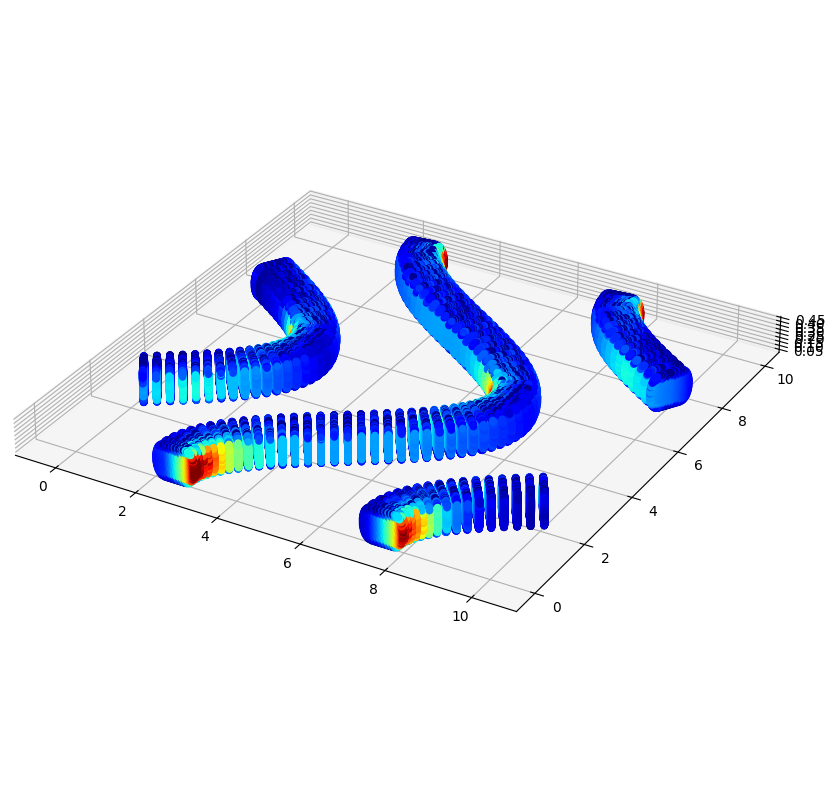

In [22]:
#sections plot 

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111,projection='3d')

ax.set_box_aspect([1,1,1])
sections = final_sections[1]
for isection in sections:

    X = isection["X"]
    Y = isection["Y"]
    Z = isection["Z"]
    P1 = isection["P1"]
    ax.scatter(X,Y,Z,c=P1,vmax=1000,vmin=0,cmap="jet")
    #ax.scatter(X,Y,Z,c=P1,marker="o",s=0.5)

# aspect 
ax.set_box_aspect([1,1,0.075])

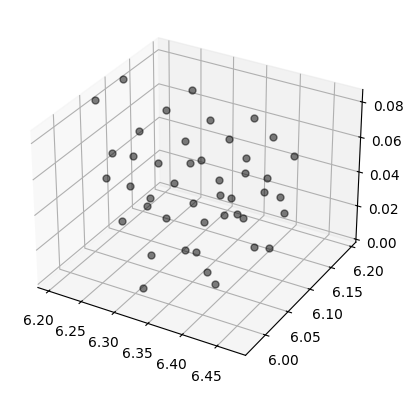

In [23]:
# plot scatter nodes_matrix 

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

plt.plot(nodes_matrix["x"],
         nodes_matrix["y"],
         nodes_matrix["z"],marker='o', alpha=0.5, color='k', 
         markersize=5,linestyle='None')

plt.show()


In [24]:
Sapl_list_design[0]

[np.float64(0.0),
 np.float64(54.29993959906964),
 np.float64(108.59985788623872)]

In [25]:
P1_time_matrix_design[0]

[np.float64(0.0),
 np.float64(221.06975582735694),
 np.float64(442.1404631255784)]

In [26]:
P1_time_design[0]

[np.float64(0.0), np.float64(192.381074111234), np.float64(384.7620391435059)]

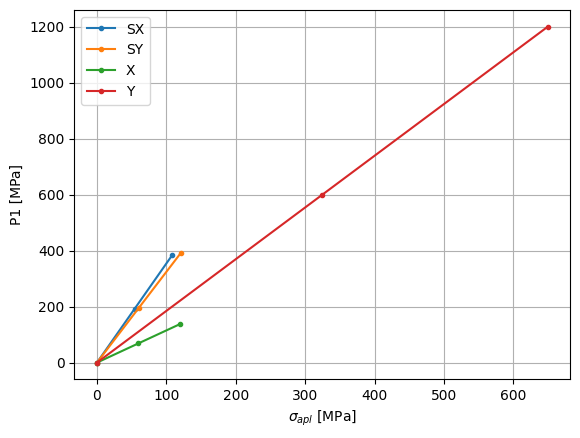

In [27]:
fig = plt.figure()
labels = ["SX","SY","X","Y"]
for ii in range(4):
    plt.plot(Sapl_list_design[ii],P1_time_design[ii],'.-', label=labels[ii])
plt.xlabel(r"$\sigma_{apl}$ [MPa]")
plt.ylabel("P1 [MPa]")
plt.legend()
plt.grid()  

In [28]:
P1_time_design

[[np.float64(0.0),
  np.float64(192.381074111234),
  np.float64(384.7620391435059)],
 [np.float64(0.0),
  np.float64(196.3264688484928),
  np.float64(392.65299409073555)],
 [np.float64(0.0),
  np.float64(68.70987412463546),
  np.float64(137.41976094100715)],
 [np.float64(0.0),
  np.float64(600.2805615701832),
  np.float64(1200.5610923618453)]]

In [29]:
ratio_fibra = [ P1_time_design[ii][-1]/Sapl_list_design[ii][-1] for ii in range(4)]
ratio_matrix = [ P1_time_matrix_design[ii][-1]/Sapl_list_design[ii][-1] for ii in range(4)]
ratio = {
    "SX": {"fibra": ratio_fibra[0], "matrix": ratio_matrix[0]},
    "SY": {"fibra": ratio_fibra[1], "matrix": ratio_matrix[1]},
    "X": {"fibra": ratio_fibra[2], "matrix": ratio_matrix[2]},
    "Y": {"fibra": ratio_fibra[3], "matrix": ratio_matrix[3]}
}

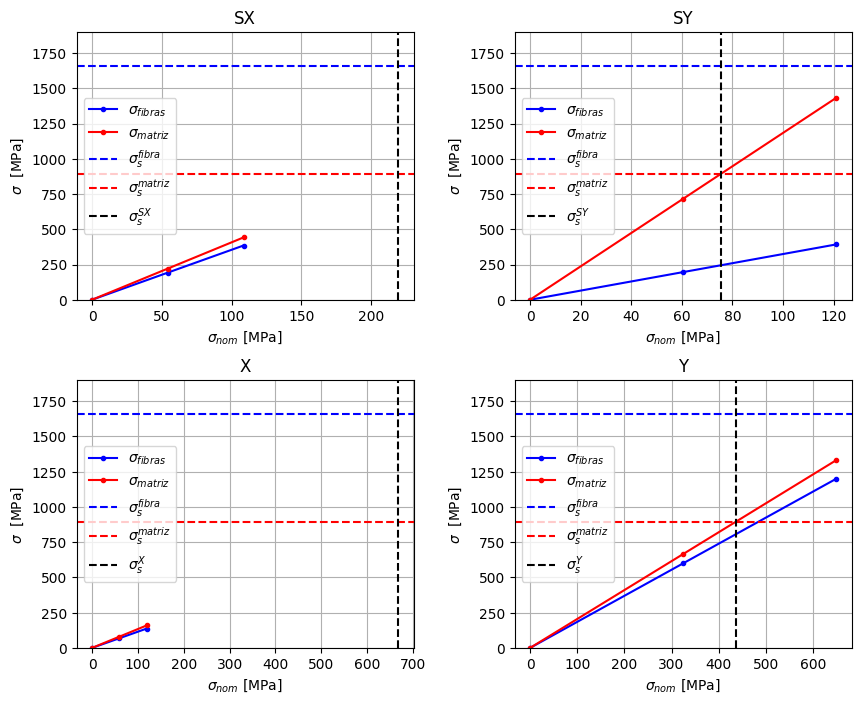

In [30]:
labels = ["SX","SY","X","Y"]
fig = plt.figure(figsize=(10, 8))
#subplot 
plt.subplots_adjust(wspace=0.3, 
                    hspace=0.3)

Sfibre = 1658.034
Smatrix = 893.827



colors = ["b","r"]

Srotura = {}
for ii in range(4):

    # subplot 
    plt.subplot(2,2,ii+1)
    plt.plot(Sapl_list_design[ii],P1_time_design[ii],'.-', label=r"$\sigma_{fibras}$",color='b')
    plt.plot(Sapl_list_design[ii],P1_time_matrix_design[ii],'.-', label= r"$\sigma_{matriz}$",color='r')
    
    plt.axhline(y=Sfibre, linestyle='--', label=r"$\sigma_s^{fibra}$",color='b')
    plt.axhline(y=Smatrix, linestyle='--', label=r"$\sigma_s^{matriz}$",color='r')

    Sposibles  = [Sfibre/ratio[labels[ii]]["fibra"],Smatrix/ratio[labels[ii]]["matrix"]]
    idx_S = np.argmin(Sposibles)
    S = Sposibles[idx_S]

    Srotura[labels[ii]] = S

    label = r"$\sigma_s^{CC}$"  
    label = label.replace("CC",labels[ii])
    plt.axvline(x=S, linestyle='--', 
                label=label,
                color="k")

    # [0,0] -> [ S,]
    plt.xlabel(r"$\sigma_{nom}$ [MPa]")
    plt.ylabel(r"$\sigma$  [MPa]")
    plt.title(labels[ii])
    plt.legend()
    plt.grid()  
    plt.ylim(0,1900)


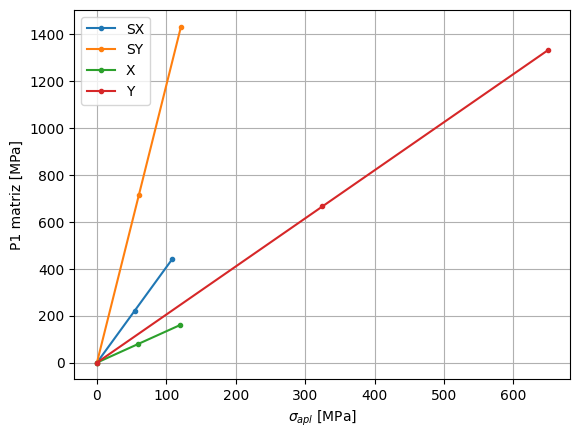

In [31]:
fig = plt.figure()
labels = ["SX","SY","X","Y"]
for ii in range(4):
    plt.plot(Sapl_list_design[ii],P1_time_matrix_design[ii],'.-', label=labels[ii])
plt.xlabel(r"$\sigma_{apl}$ [MPa]")
plt.ylabel("P1 matriz [MPa]")
plt.legend()
plt.grid()  

In [32]:
Srotura

{'SX': np.float64(219.5444508486731),
 'SY': np.float64(75.50321610195739),
 'X': np.float64(667.8801602276629),
 'Y': np.float64(435.72083949956937)}

In [33]:

ratio

{'SX': {'fibra': np.float64(3.542933173508887),
  'matrix': np.float64(4.0712803104100965)},
 'SY': {'fibra': np.float64(3.2434058309582157),
  'matrix': np.float64(11.83826393292971)},
 'X': {'fibra': np.float64(1.151025342691673),
  'matrix': np.float64(1.3383044642250155)},
 'Y': {'fibra': np.float64(1.848311724711977),
  'matrix': np.float64(2.051375373797983)}}

In [34]:
import pandas as pd 
pd.DataFrame(ratio)

,SX,SY,X,Y
fibra,3.542933,3.243406,1.151025,1.848312
matrix,4.071280,11.838264,1.338304,2.051375


In [35]:
ratio

{'SX': {'fibra': np.float64(3.542933173508887),
  'matrix': np.float64(4.0712803104100965)},
 'SY': {'fibra': np.float64(3.2434058309582157),
  'matrix': np.float64(11.83826393292971)},
 'X': {'fibra': np.float64(1.151025342691673),
  'matrix': np.float64(1.3383044642250155)},
 'Y': {'fibra': np.float64(1.848311724711977),
  'matrix': np.float64(2.051375373797983)}}

In [39]:
from loadsavejson.savejson import savejson

In [40]:
savejson(ratio,"ratio.json")

In [36]:
P1_time_design

[[np.float64(0.0),
  np.float64(192.381074111234),
  np.float64(384.7620391435059)],
 [np.float64(0.0),
  np.float64(196.3264688484928),
  np.float64(392.65299409073555)],
 [np.float64(0.0),
  np.float64(68.70987412463546),
  np.float64(137.41976094100715)],
 [np.float64(0.0),
  np.float64(600.2805615701832),
  np.float64(1200.5610923618453)]]

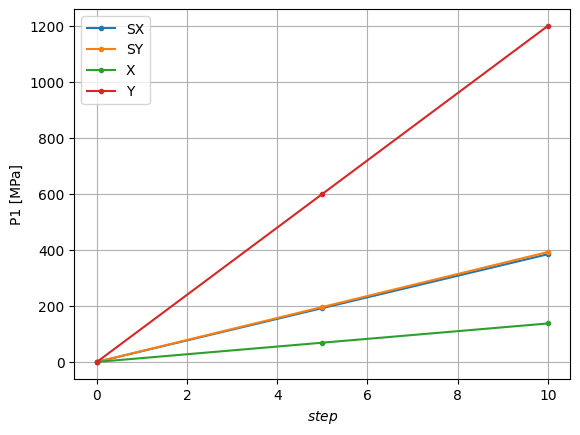

In [37]:
fig = plt.figure()
labels = ["SX","SY","X","Y"]
epsilon = np.linspace(0,1,3)/0.1
for ii in range(4):
    plt.plot(epsilon,P1_time_design[ii],'.-', label=labels[ii])
plt.xlabel(r"$step$")
plt.ylabel("P1 [MPa]")
plt.legend()
plt.grid()  

In [38]:
t_l = 0.475 #  Espesor de la capa [mm]
t_n = 2.934

r = 3*t_l/8 
d = (A_s - np.pi*r**2)/(2*r) # Area de la capa [mm^2]
params_composite ={
    "r"         :  r,
    "d"         :  d,
    "h"         :  t_l,
    "z0"        :  0,
    "density"   : 5,
}

E_resina = 637.4322499999998
E_carbon = 15333.333333333334
E_nucleo = 800